# Agent Benchmark Comparison

## Imports and Configuration

In [1]:
import pandas as pd
import json
from pathlib import Path
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import re # Added for regex parsing
import os
import ast

# Set current working directory
# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Set the working directory to the project root (one level up from the notebook directory)
project_root = os.path.join(notebook_dir, os.pardir)
os.chdir(project_root)

# You can verify the new working directory
print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /home/timpi/Projects/thesis/multi_agent_supply_chain_optimization


In [2]:
# --- Directory specific imports ---
from utils import modify_and_run_model # New import

In [3]:
# --- Configuration --- 
BENCHMARK_PATH = Path('./benchmark/VRP/vrp_benchmark_10cust_2veh.csv')
AGENT_RUN_LOG_PATH = Path('./logs/run_log_20250530_190102.csv') # Example agent run log
MODEL_FILE_PATH = Path('./models/VRP/vrp_model.py')
MODEL_DATA_PATH = Path('./models/VRP/data/vrp_data_10cust_2veh.json')

benchmark_filepath = BENCHMARK_PATH
agent_log_filepath = AGENT_RUN_LOG_PATH
model_filepath = MODEL_FILE_PATH
model_data_filepath = MODEL_DATA_PATH

print(f"Loading benchmark from: {benchmark_filepath}")
print(f"Loading agent run log from: {agent_log_filepath}")
print(f"Using model file: {model_filepath}")
print(f"Using model data: {model_data_filepath}")

Loading benchmark from: benchmark/VRP/vrp_benchmark_10cust_2veh.csv
Loading agent run log from: logs/run_log_20250530_190102.csv
Using model file: models/VRP/vrp_model.py
Using model data: models/VRP/data/vrp_data_10cust_2veh.json


## Functions

In [4]:
### Helper functions
# --- Baseline Objective Calculation ---
def get_baseline_objective(model_file_path, model_data_path):
    print(f"Running baseline model from {model_file_path} with data {model_data_path}...")
    # Run the model with no modifications to get the baseline objective value
    # Log to a dedicated baseline log file
    baseline_log_filepath = "notebooks/baseline_vrp_log.csv"
    result = modify_and_run_model(
        modification_json={},
        model_file_path=str(model_file_path),
        model_data_path=str(model_data_path),
        run_id="baseline_run",
        log_filepath=baseline_log_filepath # Log to dedicated file
    )
    
    if isinstance(result, dict) and result.get('status') == 'Optimal':
        baseline_obj = result['total_cost']
        print(f"Baseline objective value: {baseline_obj}")
        return baseline_obj
    else:
        print(f"Failed to get optimal baseline objective: {result}")
        return None
    
# --- Read Baseline Log ---
def read_baseline_log(baseline_log_filepath):
    try:
        df_baseline = pd.read_csv(baseline_log_filepath)
        if not df_baseline.empty:
            print(f"Baseline log file loaded from {baseline_log_filepath}.")
            return df_baseline
        else:
            print("Baseline log file is empty.")
            return pd.DataFrame() # Return empty DataFrame
    except FileNotFoundError:
        print(f"Baseline log file not found at {baseline_log_filepath}. Please run baseline model first.")
        return pd.DataFrame() # Return empty DataFrame
    except Exception as e:
        print(f"Error reading baseline log: {e}")
        return pd.DataFrame() # Return empty DataFrame

# --- Modification JSON Parsing ---
def parse_modification_json(df, col_name='modification'):
    parsed_data = []
    for _, row in df.iterrows():
        try:
            mod_json = json.loads(row[col_name])
            mod_type = list(mod_json.keys())[0] if mod_json else None
            mod_value = mod_json[mod_type] if mod_type else None
            parsed_data.append({'modification_type': mod_type, 'modification_value': mod_value})
        except (json.JSONDecodeError, TypeError, IndexError):
            parsed_data.append({'modification_type': None, 'modification_value': None})
    return df.assign(**pd.DataFrame(parsed_data))

# --- 1. Ingestion & Normalization ---
def load_and_normalize_logs(benchmark_path, agent_log_path, baseline_objective):
    df_benchmark = pd.read_csv(benchmark_path)
    df_agent = pd.read_csv(agent_log_path)

    df_benchmark = parse_modification_json(df_benchmark, col_name='modification')
    df_agent = parse_modification_json(df_agent, col_name='code_modification')

    # Calculate delta_obj for both dataframes using the baseline
    if baseline_objective is not None:
        # Apply delta calculation only for 'Optimal' status
        df_benchmark['delta_obj'] = df_benchmark.apply(
            lambda row: row['objective_value'] - baseline_objective if row['status'] == 'Optimal' else np.nan,
            axis=1
        )
        df_agent['delta_obj'] = df_agent.apply(
            lambda row: row['objective_value'] - baseline_objective if row['status'] == 'Optimal' else np.nan,
            axis=1
        )
    else:
        print("Warning: Baseline objective not available. Delta objectives not calculated.")
        df_benchmark['delta_obj'] = np.nan
        df_agent['delta_obj'] = np.nan

    return df_benchmark, df_agent

# --- Canonical Scenario Key Creation ---
def create_canonical_key(params_data, constraints_data):
    """
    Creates a canonical, hashable key from parameters and constraints data.
    Handles JSON string, Python dictionary string (single quotes), and dictionary inputs.
    Ensures consistent ordering for comparison by converting all nested lists to tuples.
    """
    def make_hashable(obj):
        if isinstance(obj, dict):
            return tuple(sorted((k, make_hashable(v)) for k, v in obj.items()))
        elif isinstance(obj, list):
            return tuple(make_hashable(elem) for elem in obj)
        else:
            return obj

    def parse_and_make_hashable(data):
        if isinstance(data, str):
            try:
                # Try parsing as JSON (for benchmark)
                parsed = json.loads(data)
            except (json.JSONDecodeError, TypeError):
                try:
                    # Try parsing as Python literal (for agent)
                    parsed = ast.literal_eval(data)
                except (ValueError, SyntaxError, TypeError):
                    parsed = {} # Fallback for invalid string
        else:
            parsed = data if pd.notna(data) else {} # Assume it's already a dict or similar
        
        return make_hashable(parsed)

    params = parse_and_make_hashable(params_data)
    constraints = parse_and_make_hashable(constraints_data)

    # These are already hashable tuples from make_hashable
    # No need for sorted() here as make_hashable already sorts dict items
    return (params, constraints)


## Data Analysis

### 1. Run baseline model

In [5]:
# Get baseline objective
baseline_obj_value = get_baseline_objective(model_filepath, model_data_filepath)
# Read the full baseline log
baseline_log_filepath = "notebooks/baseline_vrp_log.csv"
df_baseline_full = read_baseline_log(baseline_log_filepath)


Running baseline model from models/VRP/vrp_model.py with data models/VRP/data/vrp_data_10cust_2veh.json...

log - Running optimization model...

log - Executing model source code...

log - Model execution completed.

log - Extracting optimization results...

log - Optimization results extracted.
Logging run 'baseline_run' to 'notebooks/baseline_vrp_log.csv'...
Successfully logged 1 runs to notebooks/baseline_vrp_log.csv

log - Optimization Completed.
Baseline objective value: 330.1
Baseline log file loaded from notebooks/baseline_vrp_log.csv.


### 2. Import and add JSON modification split and objective value changes

In [6]:
df_benchmark, df_agent = load_and_normalize_logs(benchmark_filepath, agent_log_filepath, baseline_obj_value)

In [7]:
print("\nBenchmark DataFrame head:")
df_benchmark.head()


Benchmark DataFrame head:


,run_id,timestamp,status,objective_value,model_file_path,model_data_path,parameters,constraints,variables,pulp_model_execution_time,modification,scenario_text,scenario_type,modification_type,modification_value,delta_obj
0,vrp_bench_20250531_032451_8,2025-05-31T03:24:53.609264,Optimal,330.1,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{""coords"": [[37.454011884736246, 95.0714306409...","{""OutDeg_1"": ""x_1_0 + x_1_10 + x_1_2 + x_1_3 +...","{""load_0"": 0.0, ""load_1"": 39.36, ""load_10"": 31...",0.004792,"{""ADD DATA"": ""demand[1] = demand[1] * (1 + 12/...",What would happen if the demand at customer 1 ...,demand-increase-customer-pct,ADD DATA,demand[1] = demand[1] * (1 + 12/100),5.684342e-14
1,vrp_bench_20250531_032451_12,2025-05-31T03:24:53.623373,Optimal,330.1,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{""coords"": [[37.454011884736246, 95.0714306409...","{""OutDeg_1"": ""x_1_0 + x_1_10 + x_1_2 + x_1_3 +...","{""load_0"": 0.0, ""load_1"": 12.48, ""load_10"": 26...",0.008564,"{""ADD DATA"": ""demand[1] = demand[1] * (1 + 16/...",What would happen if the demand at customer 1 ...,demand-increase-customer-pct,ADD DATA,demand[1] = demand[1] * (1 + 16/100),0.000000e+00
2,vrp_bench_20250531_032451_1,2025-05-31T03:24:53.626154,Optimal,330.1,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{""coords"": [[37.454011884736246, 95.0714306409...","{""OutDeg_1"": ""x_1_0 + x_1_10 + x_1_2 + x_1_3 +...","{""load_0"": 0.0, ""load_1"": 39.15, ""load_10"": 31...",0.004256,"{""ADD DATA"": ""demand[1] = demand[1] * (1 + 5/1...",What would happen if the demand at customer 1 ...,demand-increase-customer-pct,ADD DATA,demand[1] = demand[1] * (1 + 5/100),5.684342e-14
3,vrp_bench_20250531_032451_5,2025-05-31T03:24:53.748663,Optimal,330.1,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{""coords"": [[37.454011884736246, 95.0714306409...","{""OutDeg_1"": ""x_1_0 + x_1_10 + x_1_2 + x_1_3 +...","{""load_0"": 0.0, ""load_1"": 12.27, ""load_10"": 26...",0.003834,"{""ADD DATA"": ""demand[1] = demand[1] * (1 + 9/1...",What would happen if the demand at customer 1 ...,demand-increase-customer-pct,ADD DATA,demand[1] = demand[1] * (1 + 9/100),0.000000e+00
4,vrp_bench_20250531_032451_3,2025-05-31T03:24:53.918877,Optimal,330.1,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{""coords"": [[37.454011884736246, 95.0714306409...","{""OutDeg_1"": ""x_1_0 + x_1_10 + x_1_2 + x_1_3 +...","{""load_0"": 0.0, ""load_1"": 12.21, ""load_10"": 26...",0.003866,"{""ADD DATA"": ""demand[1] = demand[1] * (1 + 7/1...",What would happen if the demand at customer 1 ...,demand-increase-customer-pct,ADD DATA,demand[1] = demand[1] * (1 + 7/100),0.000000e+00


In [8]:
print("\nAgent DataFrame head:")
df_agent.head()


Agent DataFrame head:


,run_id,timestamp,status,objective_value,model_file_path,model_data_path,parameters,constraints,variables,pulp_model_execution_time,...,code_modification,planner_model,planner_temperature,coder_model,coder_temperature,agent_execution_time,delta_obj,token_usage,modification_type,modification_value
0,run_id_20250530_190102_it_0,2025-05-30T19:01:07.072700,Optimal,330.10,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{'coords': [[37.454011884736246, 95.0714306409...",{'OutDeg_1': 'x_1_0 + x_1_10 + x_1_2 + x_1_3 +...,"{'load_0': 0.0, 'load_1': 39.0, 'load_10': 31....",0.007408,...,"{""ADD DATA"": ""K = 4""}",gpt-4o-mini,0.7,gpt-4o,0.0,4.7012,5.684342e-14,"{""planner"": {""total"": 1509, ""prompt"": 1477, ""c...",ADD DATA,K = 4
1,run_id_20250530_190102_it_1,2025-05-30T19:01:23.705481,Optimal,416.89,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{'coords': [[37.454011884736246, 95.0714306409...",{'OutDeg_1': 'x_1_0 + x_1_10 + x_1_2 + x_1_3 +...,"{'load_0': 0.0, 'load_1': 17.0, 'load_10': 9.0...",0.003412,...,"{""ADD DATA"": ""Q = 30""}",gpt-4o-mini,0.7,gpt-4o,0.0,16.6241,8.679000e+01,"{""planner"": {""total"": 1570, ""prompt"": 1537, ""c...",ADD DATA,Q = 30
2,run_id_20250530_190102_it_2,2025-05-30T19:01:34.967024,Optimal,404.51,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{'coords': [[37.454011884736246, 95.0714306409...",{'OutDeg_1': 'x_1_0 + x_1_10 + x_1_2 + x_1_3 +...,"{'load_0': 0.0, 'load_1': 12.0, 'load_10': 26....",0.007287,...,"{""ADD DATA"": ""demand[2] = 20""}",gpt-4o-mini,0.7,gpt-4o,0.0,11.2581,7.441000e+01,"{""planner"": {""total"": 1642, ""prompt"": 1599, ""c...",ADD DATA,demand[2] = 20
3,run_id_20250530_190102_it_3,2025-05-30T19:01:37.391367,Infeasible,0.00,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{'coords': [[37.454011884736246, 95.0714306409...",{'OutDeg_1': 'x_1_0 + x_1_10 + x_1_2 + x_1_3 +...,"{'load_0': 0.0, 'load_1': 0.0, 'load_10': 0.0,...",0.005590,...,"{""ADD DATA"": ""Q = 20""}",gpt-4o-mini,0.7,gpt-4o,0.0,2.4238,NaN,"{""planner"": {""total"": 1710, ""prompt"": 1671, ""c...",ADD DATA,Q = 20
4,run_id_20250530_190102_it_4,2025-05-30T19:01:39.521131,Infeasible,0.00,models/VRP/vrp_model.py,models/VRP/data/vrp_data_10cust_2veh.json,"{'coords': [[37.454011884736246, 95.0714306409...",{'OutDeg_1': 'x_1_0 + x_1_10 + x_1_2 + x_1_3 +...,"{'load_0': 0.0, 'load_1': 0.0, 'load_10': 0.0,...",0.007183,...,"{""ADD DATA"": ""Q = 25""}",gpt-4o-mini,0.7,gpt-4o,0.0,2.1266,NaN,"{""planner"": {""total"": 1764, ""prompt"": 1726, ""c...",ADD DATA,Q = 25


### 3. Data Exploration

In [9]:
# --- Status Statistics ---
print("\nBenchmark Scenario Status Distribution:")
print(df_benchmark['status'].value_counts())

print("\nAgent Run Status Distribution:")
print(df_agent['status'].value_counts())


Benchmark Scenario Status Distribution:
status
Optimal       1077
Infeasible       4
Name: count, dtype: int64

Agent Run Status Distribution:
status
Optimal       12
Infeasible     8
Name: count, dtype: int64


In [10]:
# Parse the token_usage JSON column
df_agent['token_dict'] = df_agent['token_usage'].apply(json.loads)

# Extract planner and coder token counts
df_agent['planner_total_tokens']    = df_agent['token_dict'].apply(lambda d: d.get('planner', {}).get('total', 0))
df_agent['planner_prompt_tokens']   = df_agent['token_dict'].apply(lambda d: d.get('planner', {}).get('prompt', 0))
df_agent['planner_completion_tokens'] = df_agent['token_dict'].apply(lambda d: d.get('planner', {}).get('completion', 0))
df_agent['planner_total_cost']    = df_agent['token_dict'].apply(lambda d: d.get('planner', {}).get('total_cost', 0))
df_agent['coder_total_tokens']      = df_agent['token_dict'].apply(lambda d: d.get('coder', {}).get('total', 0))
df_agent['coder_prompt_tokens']     = df_agent['token_dict'].apply(lambda d: d.get('coder', {}).get('prompt', 0))
df_agent['coder_completion_tokens'] = df_agent['token_dict'].apply(lambda d: d.get('coder', {}).get('completion', 0))
df_agent['coder_total_cost']    = df_agent['token_dict'].apply(lambda d: d.get('coder', {}).get('total_cost', 0))

# Compute run-level metrics
metrics = {
    'Number of Runs': len(df_agent),
    'Total Planner Tokens': df_agent['planner_total_tokens'].sum(),
    'Total Planner Prompt Tokens': df_agent['planner_prompt_tokens'].sum(),
    'Total Planner Completion Tokens': df_agent['planner_completion_tokens'].sum(),
    'Total Planner Cost in USD': df_agent['planner_total_cost'].sum(),
    'Total Coder Tokens': df_agent['coder_total_tokens'].sum(),
    'Total Coder Prompt Tokens': df_agent['coder_prompt_tokens'].sum(),
    'Total Coder Completion Tokens': df_agent['coder_completion_tokens'].sum(),
    'Total Coder Cost in USD': df_agent['coder_total_cost'].sum(),
    'Total Tokens (Planner + Coder)': df_agent['planner_total_tokens'].sum() + df_agent['coder_total_tokens'].sum(),
    'Total Cost in USD (Planner + Coder)': df_agent['planner_total_cost'].sum() + df_agent['coder_total_cost'].sum(),
    'Minimum Objective Value': df_agent['objective_value'].min(),
    'Average Objective Value': df_agent['objective_value'].mean(),
    'Maximum Objective Value': df_agent['objective_value'].max(),
    'Average ΔObj': df_agent['delta_obj'].mean()
}

# Display the metrics as a DataFrame
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])

metrics_df

,Value
Number of Runs,20.000000
Total Planner Tokens,42265.000000
Total Planner Prompt Tokens,41479.000000
Total Planner Completion Tokens,786.000000
Total Planner Cost in USD,0.004476
Total Coder Tokens,57852.000000
Total Coder Prompt Tokens,57488.000000
Total Coder Completion Tokens,364.000000
Total Coder Cost in USD,0.080480
Total Tokens (Planner + Coder),100117.000000


In [11]:
# Efficiency metrics
# Compute LLM overhead
df_agent['llm_overhead_sec'] = df_agent['agent_execution_time'] - df_agent['pulp_model_execution_time']

efficiency_summary = {
    'Avg Scenario Time (s)': df_agent['agent_execution_time'].mean(),
    'Avg Solver Time (s)': df_agent['pulp_model_execution_time'].mean(),
    'Avg LLM Overhead (s)': df_agent['llm_overhead_sec'].mean(),
    'Scenarios per Minute': 60 / df_agent['agent_execution_time'].mean(),
    'Avg Planner Tokens': df_agent['planner_total_tokens'].mean(),
    'Avg Coder Tokens': df_agent['coder_total_tokens'].mean(),
    'Avg Planner Cost (USD)': df_agent['planner_total_cost'].mean(),
    'Avg Coder Cost (USD)': df_agent['coder_total_cost'].mean(),
    'Cost-Impact Ratio (USD per |ΔObj|)': (df_agent['planner_total_cost'] + df_agent['coder_total_cost']).sum() / df_agent['delta_obj'].abs().sum()
}
efficiency_df = pd.DataFrame.from_dict(efficiency_summary, orient='index', columns=['Value'])

efficiency_df

,Value
Avg Scenario Time (s),5.210850
Avg Solver Time (s),0.005706
Avg LLM Overhead (s),5.205144
Scenarios per Minute,11.514436
Avg Planner Tokens,2113.250000
Avg Coder Tokens,2892.600000
Avg Planner Cost (USD),0.000224
Avg Coder Cost (USD),0.004024
Cost-Impact Ratio (USD per |ΔObj|),0.000163


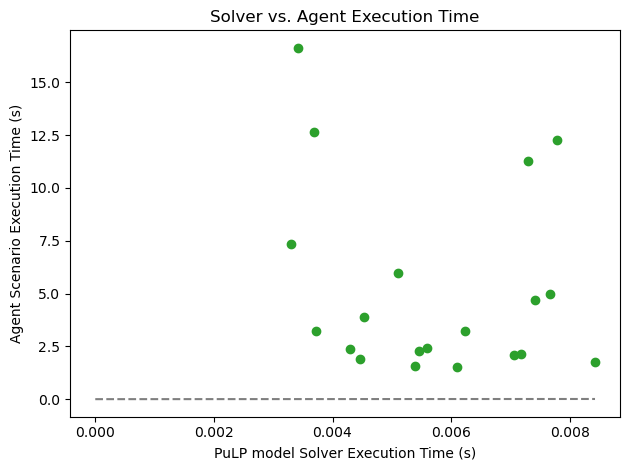

In [12]:
# Solver vs. Agent Execution Time
plt.figure()
plt.scatter(df_agent['pulp_model_execution_time'], df_agent['agent_execution_time'], c='tab:green')
plt.title('Solver vs. Agent Execution Time')
plt.xlabel('PuLP model Solver Execution Time (s)')
plt.ylabel('Agent Scenario Execution Time (s)')
plt.plot([0, df_agent['pulp_model_execution_time'].max()],
         [0, df_agent['pulp_model_execution_time'].max()], 'k--', alpha=0.5)
plt.tight_layout()

#### 3.1 Benchmark

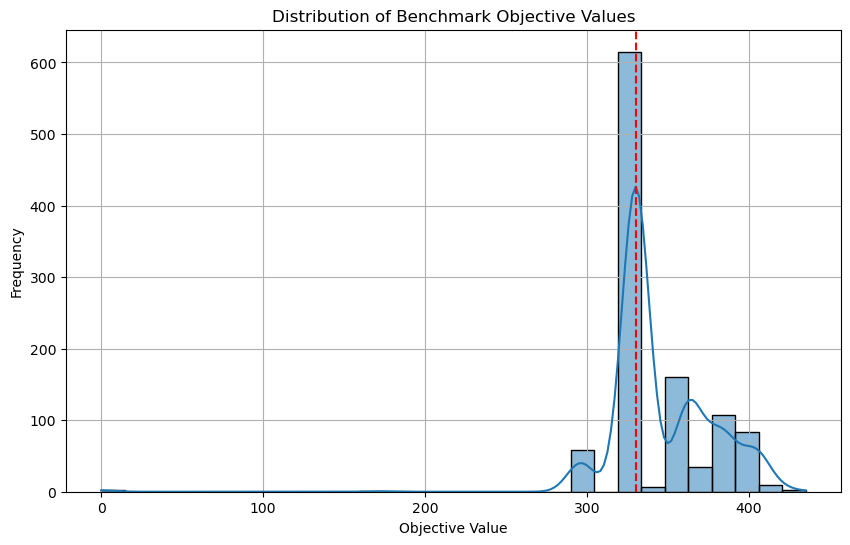

In [13]:
# Plotting Benchmark Objective Value Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_benchmark['objective_value'].dropna(), kde=True, bins=30)
plt.axvline(baseline_obj_value, color='red', linestyle='--', 
            label=f'Base objective: {baseline_obj_value:.2f}')
plt.title('Distribution of Benchmark Objective Values')
plt.xlabel('Objective Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

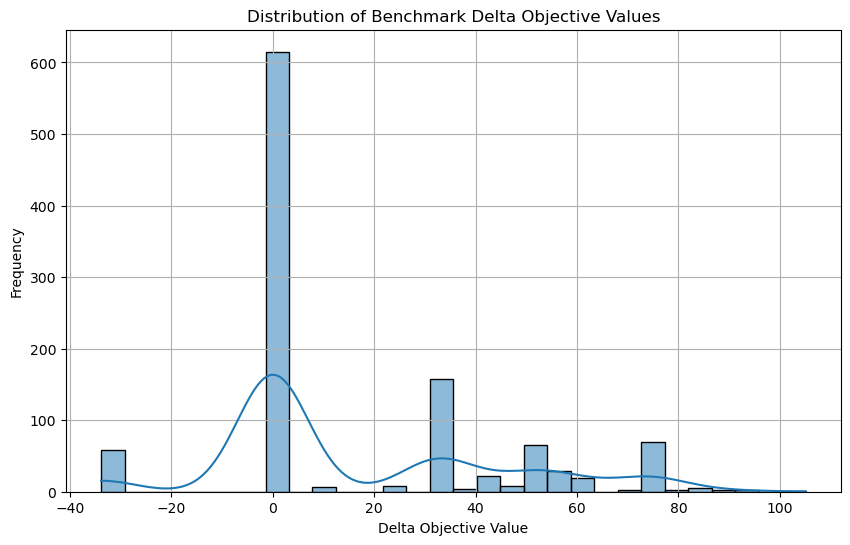

In [14]:
## Benchmark Analysis
# Plotting Benchmark Objective Value Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_benchmark['delta_obj'].dropna(), kde=True, bins=30)
plt.title('Distribution of Benchmark Delta Objective Values')
plt.xlabel('Delta Objective Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [15]:
# Displaying Top-K Benchmark Scenarios by Absolute Delta Objective Value
K = 10 # Define K for top scenarios
print(f"\nTop {K} Benchmark Scenarios by Absolute Delta Objective Value:")
# Sort by absolute delta_obj in descending order
top_k_benchmark = df_benchmark.sort_values(by='delta_obj', key=abs, ascending=False).head(K)
top_k_benchmark[['scenario_text', 'scenario_type', 'objective_value', 'delta_obj']]


Top 10 Benchmark Scenarios by Absolute Delta Objective Value:


,scenario_text,scenario_type,objective_value,delta_obj
763,Suppose vehicle capacity changed to 28. How do...,capacity-change,435.18,105.08
1080,"What if vehicle must traverse arc (10, 5)?",force-arc,424.12,94.02
1032,"What if vehicle must traverse arc (5, 10)?",force-arc,424.12,94.02
760,Suppose vehicle capacity changed to 29. How do...,capacity-change,416.89,86.79
617,What would happen if we changed the demand of ...,demand-increase-customer-int,416.89,86.79
764,Suppose vehicle capacity changed to 30. How do...,capacity-change,416.89,86.79
1079,"What if vehicle must traverse arc (10, 3)?",force-arc,416.23,86.13
1005,"What if vehicle must traverse arc (3, 10)?",force-arc,416.23,86.13
1040,"What if vehicle must traverse arc (6, 5)?",force-arc,415.94,85.84
1021,"What if vehicle must traverse arc (5, 6)?",force-arc,415.94,85.84


#### 3.2 Agent

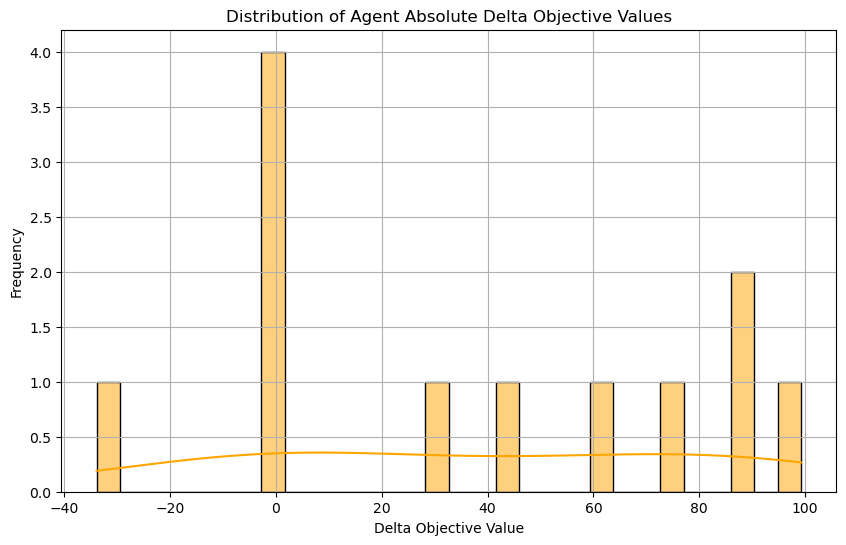

In [16]:
# Plotting Agent Absolute Delta Objective Value Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_agent['delta_obj'].dropna(), kde=True, bins=30, color='orange')
plt.title('Distribution of Agent Absolute Delta Objective Values')
plt.xlabel('Delta Objective Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [17]:
# Displaying Top-K Agent Scenarios by Absolute Delta Objective Value
K = 10 # Use the same K as for benchmark
print(f"\nTop {K} Agent Scenarios by Absolute Delta Objective Value:")
# Sort by absolute delta_obj in descending order
top_k_agent = df_agent.sort_values(by='delta_obj', key=abs, ascending=False).head(K)
top_k_agent[['scenario_text', 'objective_value', 'delta_obj', 'code_modification']]


Top 10 Agent Scenarios by Absolute Delta Objective Value:


,scenario_text,objective_value,delta_obj,code_modification
8,Scenario: 'Increase the demand of customer 6 f...,429.34,9.924000e+01,"{""ADD DATA"": ""demand[6] = 30""}"
11,Increase the demand of customer 9 from 5 to 50...,420.01,8.991000e+01,"{""ADD DATA"": ""demand[9] = 50""}"
1,Decrease the vehicle capacity from 50 to 30 to...,416.89,8.679000e+01,"{""ADD DATA"": ""Q = 30""}"
2,Scenario: 'Increase the demand of customer 2 f...,404.51,7.441000e+01,"{""ADD DATA"": ""demand[2] = 20""}"
10,Increase the demand of customer 1 from 0 to 15...,393.39,6.329000e+01,"{""ADD DATA"": ""demand[1] = 15""}"
14,Increase the demand of customer 8 from 3 to 40...,372.46,4.236000e+01,"{""ADD DATA"": ""demand[8] = 40""}"
18,Increase the vehicle capacity from 50 to 70 wh...,296.26,-3.384000e+01,"{""ADD DATA"": ""Q = 70""}"
9,Increase the demand of customer 4 from 9 to 35...,362.57,3.247000e+01,"{""ADD DATA"": ""demand[4] = 35""}"
0,Increase the number of vehicles from 2 to 4 wh...,330.10,5.684342e-14,"{""ADD DATA"": ""K = 4""}"
6,Increase the demand of customer 5 from 9 to 25...,330.10,5.684342e-14,"{""ADD DATA"": ""demand[5] = 25""}"


#### 3.3 Check for any overlap between agent and benchmark

In [18]:
# Create canonical scenario keys
df_benchmark['scenario_key'] = df_benchmark.apply(
    lambda row: create_canonical_key(row['parameters'], row['constraints']), axis=1
    )
df_agent['scenario_key'] = df_agent.apply(
    lambda row: create_canonical_key(row['parameters'], row['constraints']), axis=1
)

In [19]:
df_benchmark['scenario_key'].head()

0    (((K, 2), (Q, 50), (coords, ((37.4540118847362...
1    (((K, 2), (Q, 50), (coords, ((37.4540118847362...
2    (((K, 2), (Q, 50), (coords, ((37.4540118847362...
3    (((K, 2), (Q, 50), (coords, ((37.4540118847362...
4    (((K, 2), (Q, 50), (coords, ((37.4540118847362...
Name: scenario_key, dtype: object

In [20]:
df_agent['scenario_key'].head()

0    (((K, 4), (Q, 50), (coords, ((37.4540118847362...
1    (((K, 2), (Q, 30), (coords, ((37.4540118847362...
2    (((K, 2), (Q, 50), (coords, ((37.4540118847362...
3    (((K, 2), (Q, 20), (coords, ((37.4540118847362...
4    (((K, 2), (Q, 25), (coords, ((37.4540118847362...
Name: scenario_key, dtype: object

In [21]:
# Matching Scenarios
# Merge agent runs with benchmark data based on scenario_key
# Use a left merge to keep all agent runs and find their corresponding benchmark
df_merged = pd.merge(
    df_agent,
    df_benchmark[['scenario_key', 'delta_obj', 'objective_value', 'scenario_text', 'scenario_type']].rename(
        columns={
            'delta_obj': 'benchmark_delta_obj',
            'objective_value': 'benchmark_objective_value',
            'scenario_text': 'benchmark_scenario_text',
            'scenario_type': 'benchmark_scenario_type'
        }
    ),
    on='scenario_key',
    how='left',
    suffixes=('_agent', '_benchmark')
)

In [22]:
matched_agent_runs = df_merged[df_merged['benchmark_delta_obj'].notna()]
print(f"\nNumber of agent runs not found in benchmark: {len(matched_agent_runs)}")
print("\nMerged DataFrame head (showing matched scenarios):")
matched_agent_runs[['run_id', 'delta_obj', 'benchmark_delta_obj', 'benchmark_scenario_text']].head()


Number of agent runs not found in benchmark: 6

Merged DataFrame head (showing matched scenarios):


,run_id,delta_obj,benchmark_delta_obj,benchmark_scenario_text
0,run_id_20250530_190102_it_0,5.684342e-14,5.684342e-14,What if we change the fleet size to 4 vehicles?
1,run_id_20250530_190102_it_1,8.679000e+01,8.679000e+01,Suppose vehicle capacity changed to 30. How do...
2,run_id_20250530_190102_it_2,7.441000e+01,7.441000e+01,What would happen if we changed the demand of ...
6,run_id_20250530_190102_it_6,5.684342e-14,5.684342e-14,What would happen if we changed the demand of ...
10,run_id_20250530_190102_it_10,6.329000e+01,6.329000e+01,What would happen if we changed the demand of ...


In [23]:
# Flag unmatched agent runs (agent tried something not in benchmark)
unmatched_agent_runs = df_merged[df_merged['benchmark_delta_obj'].isna()]
print(f"\nNumber of agent runs not found in benchmark: {len(unmatched_agent_runs)}")
print("Examples of unmatched agent runs:")
unmatched_agent_runs[['run_id', 'code_modification', 'delta_obj', 'status']].head()
    


Number of agent runs not found in benchmark: 14
Examples of unmatched agent runs:


,run_id,code_modification,delta_obj,status
3,run_id_20250530_190102_it_3,"{""ADD DATA"": ""Q = 20""}",NaN,Infeasible
4,run_id_20250530_190102_it_4,"{""ADD DATA"": ""Q = 25""}",NaN,Infeasible
5,run_id_20250530_190102_it_5,"{""ADD DATA"": ""Q = 15""}",NaN,Infeasible
7,run_id_20250530_190102_it_7,"{""ADD DATA"": ""Q = 10""}",NaN,Infeasible
8,run_id_20250530_190102_it_8,"{""ADD DATA"": ""demand[6] = 30""}",99.24,Optimal


## 4. Performance Metrics

### 4.1 Top-K Coverage (Magnitude-based)

In [24]:
### 4.1 Top-K Coverage (Magnitude-based)

# Define K for top scenarios (can be adjusted)
K_coverage = 10 

# Get the top K benchmark scenarios by absolute delta_obj
top_k_benchmark_deltas = df_benchmark.sort_values(by='delta_obj', key=abs, ascending=False).head(K_coverage)

# Get the range of delta_obj values for these top K scenarios
# We'll consider the minimum and maximum absolute delta_obj from the top K
min_top_k_abs_delta = top_k_benchmark_deltas['delta_obj'].abs().min()
max_top_k_abs_delta = top_k_benchmark_deltas['delta_obj'].abs().max()

print(f"\nTop {K_coverage} Benchmark Scenarios (Absolute Delta Objective Range):")
print(f"Min Abs Delta: {min_top_k_abs_delta:.2f}, Max Abs Delta: {max_top_k_abs_delta:.2f}")

# Count how many agent scenarios fall within this range
# We consider an agent scenario "covered" if its absolute delta_obj is within the range
# of the top K benchmark scenarios.
agent_covered_by_magnitude = df_agent[
    (df_agent['delta_obj'].abs() >= min_top_k_abs_delta) & 
    (df_agent['delta_obj'].abs() <= max_top_k_abs_delta)
]

num_agent_covered = len(agent_covered_by_magnitude)
total_agent_scenarios = len(df_agent.dropna(subset=['delta_obj'])) # Only count scenarios with valid delta_obj

print(f"\nNumber of agent scenarios with absolute delta objective within Top {K_coverage} benchmark range: {num_agent_covered}")
if total_agent_scenarios > 0:
    percentage_covered = (num_agent_covered / total_agent_scenarios) * 100
    print(f"Percentage of agent scenarios covered by magnitude: {percentage_covered:.2f}%")
else:
    print("No valid agent scenarios to calculate percentage coverage.")

if not agent_covered_by_magnitude.empty:
    print("\nExamples of agent scenarios covered by magnitude:")
    print(agent_covered_by_magnitude[['run_id', 'delta_obj', 'code_modification']].head())





Top 10 Benchmark Scenarios (Absolute Delta Objective Range):
Min Abs Delta: 85.84, Max Abs Delta: 105.08

Number of agent scenarios with absolute delta objective within Top 10 benchmark range: 3
Percentage of agent scenarios covered by magnitude: 25.00%

Examples of agent scenarios covered by magnitude:
                          run_id  delta_obj               code_modification
1    run_id_20250530_190102_it_1      86.79          {"ADD DATA": "Q = 30"}
8    run_id_20250530_190102_it_8      99.24  {"ADD DATA": "demand[6] = 30"}
11  run_id_20250530_190102_it_11      89.91  {"ADD DATA": "demand[9] = 50"}


### 4.2 Sequential Performance Curves

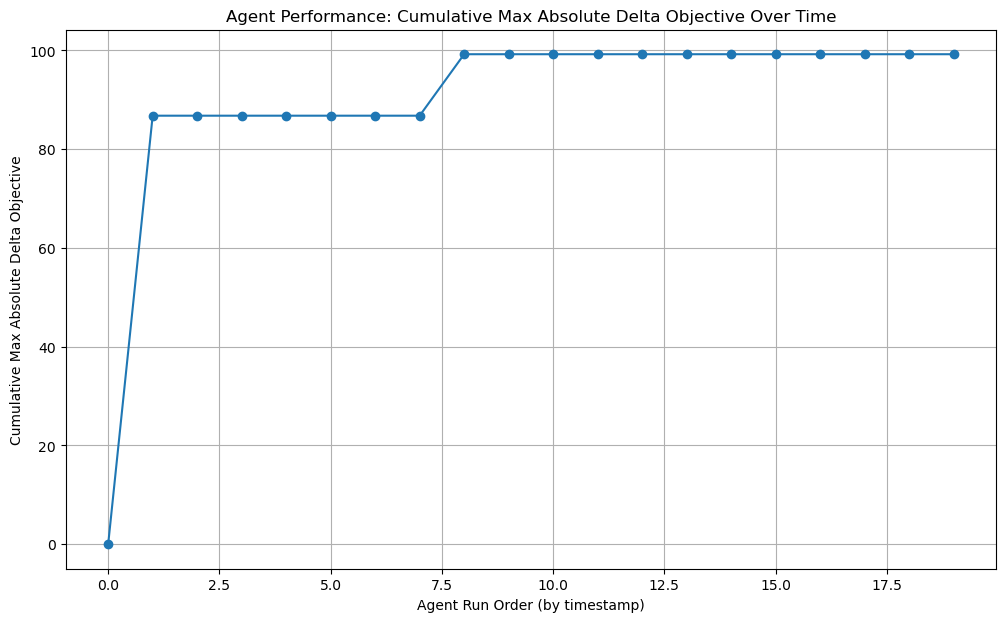

In [25]:
### 4.2 Sequential Performance Curves

# Ensure agent runs are sorted by timestamp for sequential analysis
df_agent_sorted = df_agent.sort_values(by='timestamp').copy()

# Calculate cumulative best-so-far absolute delta objective
df_agent_sorted['cumulative_max_abs_delta'] = df_agent_sorted['delta_obj'].abs().expanding().max()

plt.figure(figsize=(12, 7))
plt.plot(df_agent_sorted.index, df_agent_sorted['cumulative_max_abs_delta'], marker='o', linestyle='-')
plt.title('Agent Performance: Cumulative Max Absolute Delta Objective Over Time')
plt.xlabel('Agent Run Order (by timestamp)')
plt.ylabel('Cumulative Max Absolute Delta Objective')
plt.grid(True)
plt.show()

### 4.3 Absolute Ranking of Agent Scenarios within Benchmark Context

In [26]:
### 4.3 Absolute Ranking of Agent Scenarios within Benchmark Context

# Combine benchmark and agent scenarios for ranking
# We need to ensure unique identifiers if run_id's overlap, but for ranking,
# we can just combine their delta_obj values.
# Create a temporary DataFrame with relevant columns for ranking
df_combined_for_ranking = pd.DataFrame({
    'source': ['benchmark'] * len(df_benchmark) + ['agent'] * len(df_agent),
    'run_id': list(df_benchmark['run_id']) + list(df_agent['run_id']),
    'delta_obj': list(df_benchmark['delta_obj']) + list(df_agent['delta_obj'])
})

# Sort by absolute delta_obj in descending order to assign ranks
df_combined_for_ranking['abs_delta_obj'] = df_combined_for_ranking['delta_obj'].abs()
df_combined_for_ranking_sorted = df_combined_for_ranking.sort_values(by='abs_delta_obj', ascending=False).reset_index(drop=True)

# Assign rank
df_combined_for_ranking_sorted['rank'] = df_combined_for_ranking_sorted.index + 1

print("\nCombined Benchmark and Agent Scenarios with Absolute Ranks (Top 10):")
print(df_combined_for_ranking_sorted.head(10))


Combined Benchmark and Agent Scenarios with Absolute Ranks (Top 10):
      source                          run_id  delta_obj  abs_delta_obj  rank
0  benchmark   vrp_bench_20250531_033000_760     105.08         105.08     1
1      agent     run_id_20250530_190102_it_8      99.24          99.24     2
2  benchmark  vrp_bench_20250531_033106_1026      94.02          94.02     3
3  benchmark  vrp_bench_20250531_033114_1076      94.02          94.02     4
4      agent    run_id_20250530_190102_it_11      89.91          89.91     5
5  benchmark   vrp_bench_20250531_033000_761      86.79          86.79     6
6  benchmark   vrp_bench_20250531_032804_610      86.79          86.79     7
7      agent     run_id_20250530_190102_it_1      86.79          86.79     8
8  benchmark   vrp_bench_20250531_033003_762      86.79          86.79     9
9  benchmark  vrp_bench_20250531_033114_1074      86.13          86.13    10


In [27]:
# Filter for agent scenarios and show their ranks
agent_ranks = df_combined_for_ranking_sorted[df_combined_for_ranking_sorted['source'] == 'agent']
print("\nAgent Scenarios with their Absolute Ranks (Top 20):")
print(agent_ranks.head(20))

# You can also analyze specific agent runs' ranks
# For example, to find the rank of the most impactful agent scenario:
if not agent_ranks.empty:
    most_impactful_agent_run_rank = agent_ranks.iloc[0]['rank']
    print(f"\nRank of the most impactful agent scenario: {most_impactful_agent_run_rank}")



Agent Scenarios with their Absolute Ranks (Top 20):
     source                        run_id     delta_obj  abs_delta_obj  rank
1     agent   run_id_20250530_190102_it_8  9.924000e+01   9.924000e+01     2
4     agent  run_id_20250530_190102_it_11  8.991000e+01   8.991000e+01     5
7     agent   run_id_20250530_190102_it_1  8.679000e+01   8.679000e+01     8
74    agent   run_id_20250530_190102_it_2  7.441000e+01   7.441000e+01    75
89    agent  run_id_20250530_190102_it_10  6.329000e+01   6.329000e+01    90
221   agent  run_id_20250530_190102_it_14  4.236000e+01   4.236000e+01   222
265   agent  run_id_20250530_190102_it_18 -3.384000e+01   3.384000e+01   266
356   agent   run_id_20250530_190102_it_9  3.247000e+01   3.247000e+01   357
496   agent  run_id_20250530_190102_it_13  5.684342e-14   5.684342e-14   497
506   agent   run_id_20250530_190102_it_6  5.684342e-14   5.684342e-14   507
508   agent   run_id_20250530_190102_it_0  5.684342e-14   5.684342e-14   509
794   agent  run_id_202

## 5. Efficiency & Cost Trade-Off

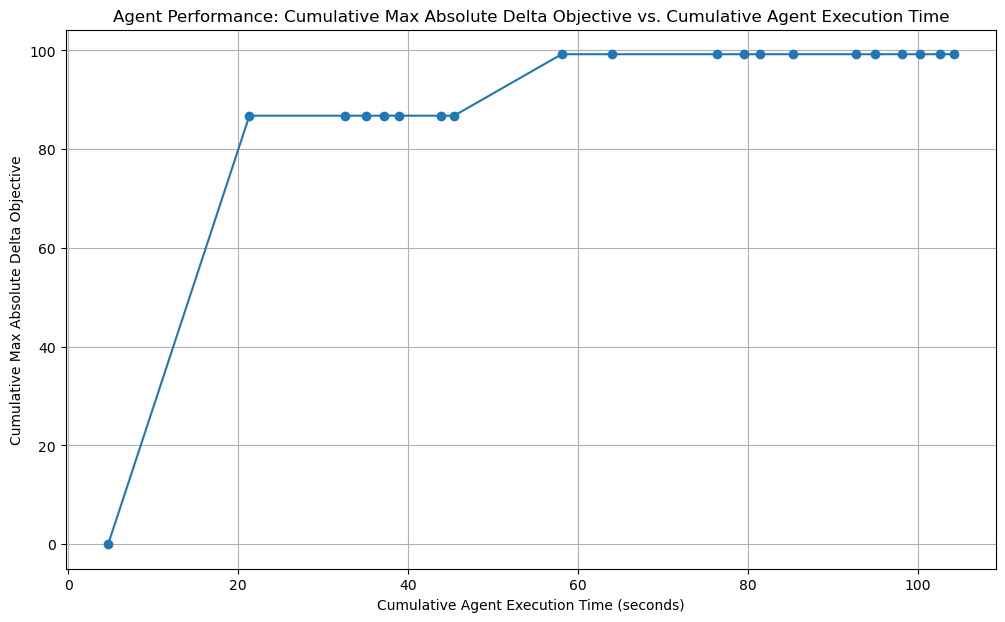

In [28]:
## 5. Efficiency & Cost Trade-Off

# Calculate cumulative agent execution time
df_agent_sorted['cumulative_agent_execution_time'] = df_agent_sorted['agent_execution_time'].cumsum()

# Calculate cumulative token usage
df_agent_sorted['cumulative_token_usage'] = df_agent_sorted['token_usage'].cumsum()

# Plot Cumulative Cost vs. Cumulative Max Absolute Delta
plt.figure(figsize=(12, 7))
plt.plot(df_agent_sorted['cumulative_agent_execution_time'], df_agent_sorted['cumulative_max_abs_delta'], marker='o', linestyle='-')
plt.title('Agent Performance: Cumulative Max Absolute Delta Objective vs. Cumulative Agent Execution Time')
plt.xlabel('Cumulative Agent Execution Time (seconds)')
plt.ylabel('Cumulative Max Absolute Delta Objective')
plt.grid(True)
plt.show()



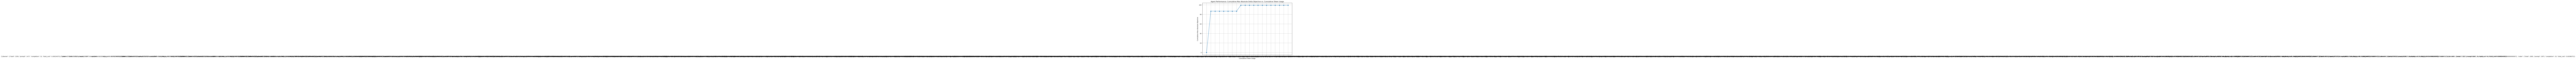

In [29]:
plt.figure(figsize=(12, 7))
plt.plot(df_agent_sorted['cumulative_token_usage'], df_agent_sorted['cumulative_max_abs_delta'], marker='o', linestyle='-')
plt.title('Agent Performance: Cumulative Max Absolute Delta Objective vs. Cumulative Token Usage')
plt.xlabel('Cumulative Token Usage')
plt.ylabel('Cumulative Max Absolute Objective') # Corrected label
plt.grid(True)
plt.show()

In [30]:
# Derive metrics
# Time to X% coverage (e.g., 80% of max delta found)
max_abs_delta_found = df_agent_sorted['cumulative_max_abs_delta'].max()
target_delta_80_percent = max_abs_delta_found * 0.8

time_to_80_percent_coverage = df_agent_sorted[
    df_agent_sorted['cumulative_max_abs_delta'] >= target_delta_80_percent
]['cumulative_agent_execution_time'].min()

print(f"\nTime to reach 80% of max absolute delta found: {time_to_80_percent_coverage:.2f} seconds")

# Cost-per-unit-impact = (total token cost) / (sum of abs delta_obj found)
# Assuming 'planner_total_tokens' and 'coder_total_tokens' are already created and numerical
total_token_cost = df_agent_sorted['planner_total_tokens'].sum() + df_agent_sorted['coder_total_tokens'].sum()
sum_of_abs_deltas_found = df_agent_sorted['delta_obj'].abs().sum()

if sum_of_abs_deltas_found > 0:
    cost_per_unit_impact = total_token_cost / sum_of_abs_deltas_found
    print(f"Cost-per-unit-impact (Tokens / Sum of Abs Deltas): {cost_per_unit_impact:.4f}")
else:
    print("Cannot calculate Cost-per-unit-impact: Sum of absolute deltas is zero.")



Time to reach 80% of max absolute delta found: 21.33 seconds
Cost-per-unit-impact (Tokens / Sum of Abs Deltas): 191.6812


## 6. Correctness & Robustness Checks

In [31]:
## 6. Correctness & Robustness Checks

# JSON validity rate (for scenario_key creation)
# Count how many scenario_keys are None (indicating parsing failure)
invalid_benchmark_keys = df_benchmark['scenario_key'].isna().sum()
invalid_agent_keys = df_agent['scenario_key'].isna().sum()

total_benchmark_runs = len(df_benchmark)
total_agent_runs = len(df_agent)

print(f"\nBenchmark Scenario Key Validity Rate: {(total_benchmark_runs - invalid_benchmark_keys) / total_benchmark_runs * 100:.2f}%")
print(f"Agent Scenario Key Validity Rate: {(total_agent_runs - invalid_agent_keys) / total_agent_runs * 100:.2f}%")

# Execution success rate (already covered by status distribution, but can be summarized)
optimal_benchmark_runs = df_benchmark[df_benchmark['status'] == 'Optimal'].shape[0]
optimal_agent_runs = df_agent[df_agent['status'] == 'Optimal'].shape[0]

print(f"\nBenchmark Optimal Solution Rate: {(optimal_benchmark_runs / total_benchmark_runs) * 100:.2f}%")
print(f"Agent Optimal Solution Rate: {(optimal_agent_runs / total_agent_runs) * 100:.2f}%")

# Mismatch rate (agent scenarios not found in benchmark)
# This was already printed, but we can formalize as a percentage
percentage_unmatched_agent = (len(unmatched_agent_runs) / total_agent_scenarios) * 100 if total_agent_scenarios > 0 else 0
print(f"\nPercentage of agent runs not found in benchmark: {percentage_unmatched_agent:.2f}%")




Benchmark Scenario Key Validity Rate: 100.00%
Agent Scenario Key Validity Rate: 100.00%

Benchmark Optimal Solution Rate: 99.63%
Agent Optimal Solution Rate: 60.00%

Percentage of agent runs not found in benchmark: 116.67%


### 6.3 Infeasible Scenario Analysis

In [32]:
### 6.3 Infeasible Scenario Analysis
print("\n--- Infeasible Scenarios ---")

# Infeasible Benchmark Scenarios
infeasible_benchmark_scenarios = df_benchmark[df_benchmark['status'] == 'Infeasible']
print(f"\nNumber of Infeasible Benchmark Scenarios: {len(infeasible_benchmark_scenarios)}")
print("Details of Infeasible Benchmark Scenarios (Top 5):")
infeasible_benchmark_scenarios[['run_id', 'scenario_text', 'modification_type', 'modification_value', 'status', 'delta_obj']].head()


--- Infeasible Scenarios ---

Number of Infeasible Benchmark Scenarios: 4
Details of Infeasible Benchmark Scenarios (Top 5):


,run_id,scenario_text,modification_type,modification_value,status,delta_obj
743,vrp_bench_20250531_033000_757,Suppose vehicle capacity changed to 25. How do...,ADD DATA,Q = 25,Infeasible,NaN
744,vrp_bench_20250531_033000_758,Suppose vehicle capacity changed to 26. How do...,ADD DATA,Q = 26,Infeasible,NaN
745,vrp_bench_20250531_033000_759,Suppose vehicle capacity changed to 27. How do...,ADD DATA,Q = 27,Infeasible,NaN
821,vrp_bench_20250531_033032_833,What if we change the fleet size to 1 vehicles?,ADD DATA,K = 1,Infeasible,NaN


In [33]:
# Infeasible Agent Scenarios
infeasible_agent_scenarios = df_agent[df_agent['status'] == 'Infeasible']
print(f"\nNumber of Infeasible Agent Scenarios: {len(infeasible_agent_scenarios)}")
print("Details of Infeasible Agent Scenarios:")
infeasible_agent_scenarios[['run_id', 'code_modification', 'status', 'delta_obj']].head(len(infeasible_agent_scenarios))

# Further analysis could involve:
# - Grouping infeasible scenarios by modification_type to see common causes.
# - Attempting to understand why specific modifications lead to infeasibility.


Number of Infeasible Agent Scenarios: 8
Details of Infeasible Agent Scenarios:


,run_id,code_modification,status,delta_obj
3,run_id_20250530_190102_it_3,"{""ADD DATA"": ""Q = 20""}",Infeasible,NaN
4,run_id_20250530_190102_it_4,"{""ADD DATA"": ""Q = 25""}",Infeasible,NaN
5,run_id_20250530_190102_it_5,"{""ADD DATA"": ""Q = 15""}",Infeasible,NaN
7,run_id_20250530_190102_it_7,"{""ADD DATA"": ""Q = 10""}",Infeasible,NaN
12,run_id_20250530_190102_it_12,"{""ADD DATA"": ""Q = 5""}",Infeasible,NaN
15,run_id_20250530_190102_it_15,"{""ADD DATA"": ""demand[7] = 50""}",Infeasible,NaN
17,run_id_20250530_190102_it_17,"{""ADD DATA"": ""Q = 5""}",Infeasible,NaN
19,run_id_20250530_190102_it_19,"{""ADD DATA"": ""demand[5] = 50""}",Infeasible,NaN
